<a href="https://colab.research.google.com/github/shashaaankk/GradientAscent/blob/main/GradientAscent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports
import pandas as pd
import numpy as np
import gpxpy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [2]:
LOCAL = True

In [3]:
if not LOCAL:
    !pip install --quiet kaggle kagglehub[pandas-datasets]
    from google.colab import files
    uploaded = files.upload()   # click to select your kaggle.json
    if 'kaggle.json' not in uploaded:
        raise FileNotFoundError("You must upload the kaggle.json you downloaded from Kaggle.")


In [4]:
if not LOCAL:
    import os, shutil
    # make sure ~/.kaggle exists
    kaggle_dir = os.path.expanduser("~/.kaggle")
    os.makedirs(kaggle_dir, exist_ok=True)

    # move and secure
    shutil.move("kaggle.json", os.path.join(kaggle_dir, "kaggle.json"))
    os.chmod(os.path.join(kaggle_dir, "kaggle.json"), 0o600)

    # sometimes needed:
    os.environ['KAGGLE_CONFIG_DIR'] = kaggle_dir


In [5]:
if not LOCAL:
    import kagglehub
    path = kagglehub.dataset_download("roccoli/gpx-hike-tracks")
else:
    !mkdir data
    !curl -L -o ./data/gpx-hike-tracks.zip https://www.kaggle.com/api/v1/datasets/download/roccoli/gpx-hike-tracks
    !unzip -o data/gpx-hike-tracks.zip -d data/

mkdir: cannot create directory ‘data’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 57.4M  100 57.4M    0     0  17.6M      0  0:00:03  0:00:03 --:--:-- 21.9M
Archive:  data/gpx-hike-tracks.zip
  inflating: data/gpx-tracks-from-hikr.org.csv  


In [ ]:
# 1. Install gpxpy (to parse .gpx files)
import gpxpy
import pandas as pd
if not LOCAL:
    !pip install --quiet gpxpy

    # 2. Import libs
    import os, glob


    csv_files = glob.glob(os.path.join(path, "**", "*.csv"), recursive=True)
    csv_path = csv_files[0]
    print("Loading:", csv_path)

else:
    csv_path = "data/gpx-tracks-from-hikr.org.csv"

# Read and inspect
df = pd.read_csv(csv_path)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()



Shape: (12141, 17)
Columns: ['_id', 'length_3d', 'user', 'start_time', 'max_elevation', 'bounds', 'uphill', 'moving_time', 'end_time', 'max_speed', 'gpx', 'difficulty', 'min_elevation', 'url', 'downhill', 'name', 'length_2d']
                        _id     length_3d       user           start_time  \
0  5afb229e8f80884aaad9c6ea  10832.953016  Bergfritz  2018-05-11 07:37:40   
1  5afb229e8f80884aaad9c6eb  12259.376315  Bergfritz  2018-05-12 07:25:08   
2  5afb229e8f80884aaad9c6ec  22980.168081       igor  2018-05-11 06:29:38   
3  5afb229e8f80884aaad9c6ed  24903.503470    rkroebl  2018-05-10 07:06:22   
4  5afb229e8f80884aaad9c6ee  19581.273819    rkroebl  2018-05-11 05:44:58   

   max_elevation                                             bounds    uphill  \
0        1934.47  {'min': {'type': 'Point', 'coordinates': [13.2...   612.880   
1        2186.21  {'min': {'type': 'Point', 'coordinates': [13.1...   614.753   
2        2265.00  {'min': {'type': 'Point', 'coordinates': [8.99... 

In [41]:
#Pre-processing 1

df = df.dropna()
# Convert time columns to datetime
df["start_time"] = pd.to_datetime(df["start_time"], format="%Y-%m-%d %H:%M:%S" , errors='coerce')
df["end_time"] = pd.to_datetime(df["end_time"], format="%Y-%m-%d %H:%M:%S" ,errors='coerce')

# Compute total duration in seconds
df["duration"] =  df["moving_time"]

# Compute break time: duration - moving_time
df["break_time"] = (df["end_time"] - df["start_time"]).dt.total_seconds() - df["moving_time"]

# Select relevant features
selected = df[["duration","length_3d", "min_elevation", "max_elevation", "break_time", "uphill", "downhill"]]

X = selected
y = df['difficulty'].str[1].astype(int)
# For Correleation/ Feature Selection
df_cleaned = X.copy()
df_cleaned['speed'] = df['length_3d'] / df['duration']
df_cleaned['difficulty'] = y

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train logistic regression
mask = X.notnull().all(axis=1) & y.notnull()
X_clean = X_scaled[mask]
y_clean = y[mask]


In [38]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(
        X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
    )

In [39]:
# Model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

/home/shashaank/M.Sc/AI Study Project/GradientAscent/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.59      0.44      0.51       157
           2       0.51      0.58      0.54       596
           3       0.43      0.70      0.53       693
           4       0.27      0.03      0.05       295
           5       0.67      0.01      0.03       152
           6       0.00      0.00      0.00        56

    accuracy                           0.47      1949
   macro avg       0.41      0.29      0.28      1949
weighted avg       0.45      0.47      0.41      1949



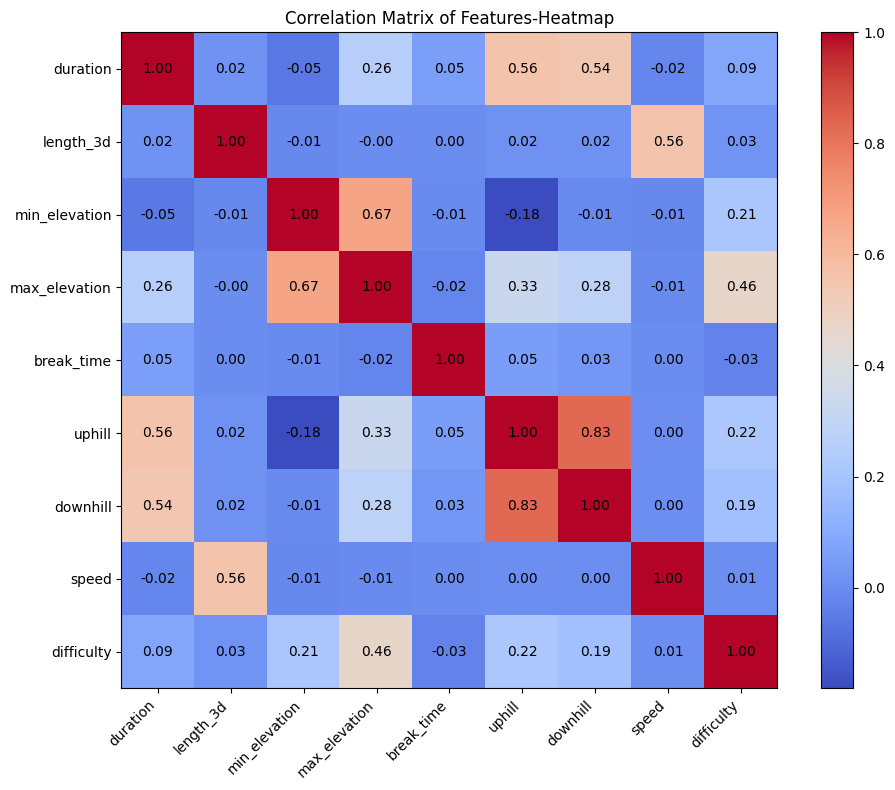

In [42]:
#PCA
# Visualize how features are related to each other
corr = df_cleaned.corr()
fig, ax = plt.subplots(figsize=(10, 8))
# heatmap
im = ax.imshow(corr.values, interpolation='nearest', cmap='coolwarm')
# ticks and labels
ticks = np.arange(len(corr.columns))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(corr.columns, rotation=45, ha='right')
ax.set_yticklabels(corr.columns)
# annotations
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        ax.text(j, i, f"{corr.iat[i, j]:.2f}", ha='center', va='center', color='black')
# colorbar
fig.colorbar(im, ax=ax)
# title and layout
ax.set_title("Correlation Matrix of Features-Heatmap")
plt.tight_layout()
plt.show()

In [ ]:
# Average Time Calulation Formula - Theoritical
def average_time_formula(length, uphill, downhill): # length in meters, uphill and downhill in percentage
    # Constants for speed calculations
    base_speed = 5.0  # Base speed in km/h
    uphill_speed_reduction = 0.5   # Speed reduction factor for uphill
    downhill_speed_increase = 1.5  # Speed increase factor for downhill

    # Calculate effective speed
    effective_speed = base_speed * (1 - uphill * uphill_speed_reduction) * (1 + downhill * downhill_speed_increase)

    # Calculate time in hours
    time_hours = length / effective_speed

    # Convert to seconds
    return time_hours * 3600  # Convert hours to seconds
